# 🔥 Mapping Wildfire Burn Severity with LeafMap & Python

Welcome to this hands-on mapping activity! In this notebook, you'll explore satellite imagery, calculate wildfire burn severity, and create your own interactive web map using open-source geospatial tools.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/asivitskis/EarthInquiryLab/blob/main/1%20-%20Burn%20Severity%20Mapping%20with%20LeafMap/Wildfire_Burn_Severity_Mapping.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/asivitskis/EarthInquiryLab/main?filepath=1%20-%20Burn%20Severity%20Mapping%20with%20LeafMap%2FWildfire_Burn_Severity_Mapping.ipynb)


## Learning Goals

By the end of this notebook, you will be able to:
- Understand and calculate the Normalized Burn Ratio (dNBR)
- Visualize burn severity using satellite imagery
- Interpret changes in vegetation using NIR/SWIR bands
- Use interactive maps to explore geographic data

## 🧰 1. Setup: Install and Import Packages

In [1]:
# If running in Colab, uncomment:
# !pip install leafmap rasterio geopandas rioxarray localtileserver -q

import leafmap
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import rioxarray
import xarray as xr
import os

## 🗺️ 2. Load and Visualize Satellite Imagery

We've prepared pre- and post-fire Landsat imagery for you. These files are hosted online for easy access.

In [ ]:
# Image Paths
prefire_path = "https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/data/prefire_LC08_038030_20230925_utm13n.tif"
postfire_path = "https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/data/postfire_LC08_037030_20250806_utm13n.tif"

# Load the images
prefire = rasterio.open(prefire_path)
postfire = rasterio.open(postfire_path)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
show(prefire.read(4), ax=ax1, title="Prefire (NIR)")
show(postfire.read(4), ax=ax2, title="Postfire (NIR)")
plt.show()

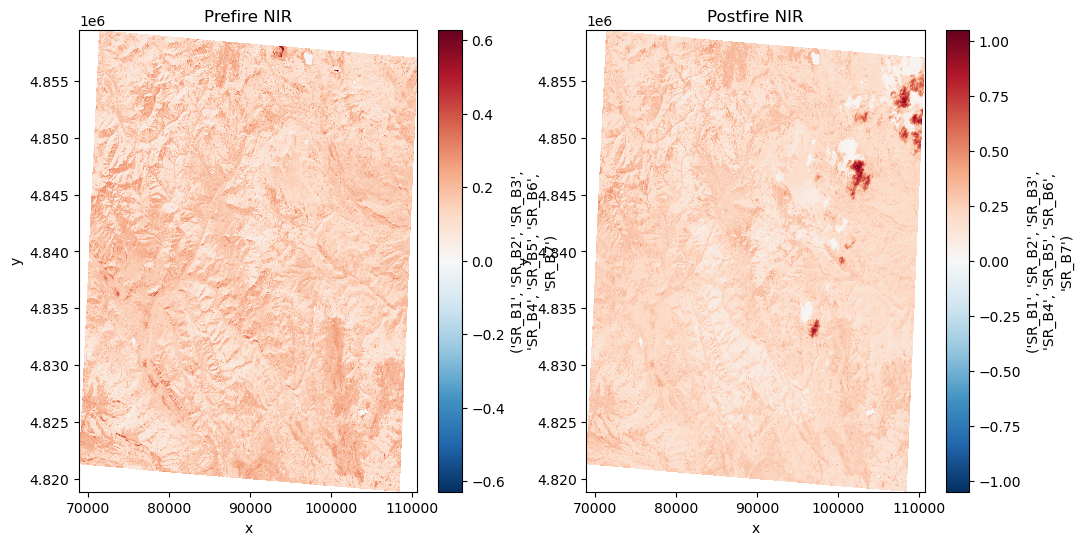

In [2]:
# Image paths
prefire_url = "https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/data/prefire_LC08_038030_20230925_utm13n.tif"
postfire_url = "https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/data/postfire_LC08_037030_20250806_utm13n.tif"

# Set Local filenames
prefire_file = "prefire.tif"
postfire_file = "postfire.tif"

# Download once
for url, fname in [(prefire_url, prefire_file), (postfire_url, postfire_file)]:
    if not os.path.exists(fname):
        import requests
        r = requests.get(url, stream=True)
        with open(fname, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Load with rioxarray
prefire = rioxarray.open_rasterio(prefire_file, masked=True)
postfire = rioxarray.open_rasterio(postfire_file, masked=True)

# Visualize NIR band (band 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
prefire[4].plot.imshow(ax=ax1)
ax1.set_title("Prefire NIR")
postfire[4].plot.imshow(ax=ax2)
ax2.set_title("Postfire NIR")
plt.show()


## 🔬 3. Calculate Burn Severity (dNBR)

In [3]:
# Read and convert to float for division
nir_pre = prefire.read(5).astype('float32')    # SR_B5 (NIR)
swir_pre = prefire.read(7).astype('float32')   # SR_B7 (SWIR2)

nir_post = postfire.read(5).astype('float32')
swir_post = postfire.read(7).astype('float32')

# Avoid divide-by-zero by setting invalid denominators to NaN
nbr_pre = (nir_pre - swir_pre) / (nir_pre + swir_pre)
nbr_pre[np.isinf(nbr_pre)] = np.nan

nbr_post = (nir_post - swir_post) / (nir_post + swir_post)
nbr_post[np.isinf(nbr_post)] = np.nan

# Calculate dNBR
dnbr = nbr_pre - nbr_post

# Plotting
import matplotlib.pyplot as plt

dnbr_masked = np.ma.masked_invalid(dnbr)
plt.figure(figsize=(10, 6))
plt.imshow(dnbr_masked, cmap='RdYlGn_r', vmin=-0.5, vmax=1)
plt.colorbar(label='dNBR Burn Severity')
plt.title("Burn Severity Map (dNBR)")
plt.axis('off')
plt.show()


AttributeError: 'DataArray' object has no attribute 'read'

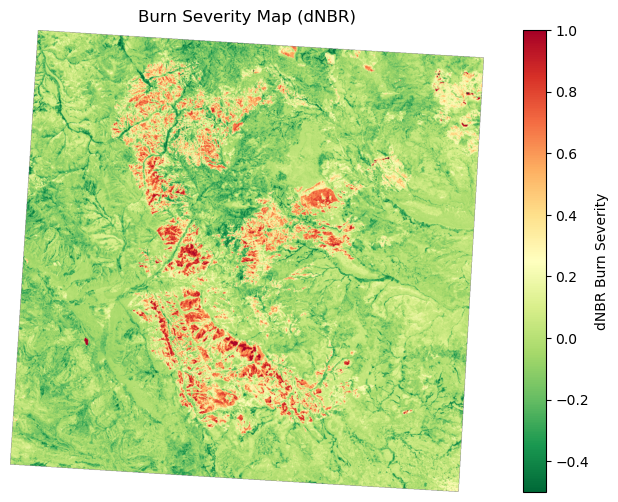

In [4]:
# Extract NIR (band 5) and SWIR2 (band 7)
nir_pre = prefire[4].data.astype('float32')
swir_pre = prefire[6].data.astype('float32')
nir_post = postfire[4].data.astype('float32')
swir_post = postfire[6].data.astype('float32')

# Calculate NBR
nbr_pre = (nir_pre - swir_pre) / (nir_pre + swir_pre)
nbr_post = (nir_post - swir_post) / (nir_post + swir_post)
nbr_pre[np.isinf(nbr_pre)] = np.nan
nbr_post[np.isinf(nbr_post)] = np.nan

# dNBR
dnbr = nbr_pre - nbr_post

# Save dNBR locally
dnbr_file = "dnbr.tif"
with rasterio.open(
    dnbr_file,
    'w',
    driver='GTiff',
    height=dnbr.shape[0],
    width=dnbr.shape[1],
    count=1,
    dtype='float32',
    crs=prefire.rio.crs,
    transform=prefire.rio.transform()
) as dst:
    dst.write(dnbr, 1)

# Quick visualization
plt.figure(figsize=(10,6))
plt.imshow(np.ma.masked_invalid(dnbr), cmap='RdYlGn_r', vmin=-0.5, vmax=1)
plt.colorbar(label='dNBR Burn Severity')
plt.title("Burn Severity Map (dNBR)")
plt.axis('off')
plt.show()


❓ What do you think a high dNBR value indicates?
❓ Why do we use NIR and SWIR bands to analyze burn severity?

## 🌍 4. Create Your Interactive Map

Use LeafMap to create and customize your interactive wildfire map.

In [6]:
# Download GeoTIFF from GitHub
url = 'https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/1%20-%20Burn%20Severity%20Mapping%20with%20LeafMap/dnbr.tif'
out_file = 'dnbr.tif'

if not os.path.exists(out_file):
    import requests
    r = requests.get(url, stream=True)
    with open(out_file, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Analyze raster values using percentiles
with rasterio.open(out_file) as src:
    band = src.read(1)
    band = band.astype('float32')
    band[band == src.nodata] = np.nan  # Mask out no-data
    vmin = np.nanpercentile(band, 2)   # 2nd percentile
    vmax = np.nanpercentile(band, 98)  # 98th percentile

print(f"Using stretch range: vmin={vmin:.3f}, vmax={vmax:.3f}")

# Display map
m = leafmap.Map(center=[38.5, -121.0], zoom=8)
m.add_raster(out_file, layer_name="Burn Severity (dNBR)", colormap='RdYlGn_r', vmin=vmin, vmax=vmax)
m

Using stretch range: vmin=-0.125, vmax=0.686


Map(center=[43.592339499999994, -110.0820925], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

In [5]:
def classify_dnbr(input_path, output_path):
    with rasterio.open(input_path) as src:
        data = src.read(1).astype('float32')
        data[data == src.nodata] = np.nan
        transform = src.transform
        crs = src.crs

    # USGS classification intervals
    intervals = [-np.inf, -0.251, -0.100, 0.100, 0.270, 0.440, 0.660, 2.000, np.inf]
    classified = np.digitize(data, intervals) - 1
    classified[np.isnan(data)] = 8  # NoData class

    # Save classified raster
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=classified.shape[0],
        width=classified.shape[1],
        count=1,
        dtype="uint8",
        crs=crs,
        transform=transform,
        compress="lzw"
    ) as dst:
        dst.write(classified.astype('uint8'), 1)
    return classified

classified_file = "dnbr_classified.tif"
classified = classify_dnbr(dnbr_file, classified_file)


In [6]:
# Colormap & labels
colormap = [
    "#ffffff", "#7a8737", "#acbe4d", "#0ae042", "#fff70b",
    "#ffaf38", "#ff641b", "#a41fd6", "#ffffff"
]

labels = [
    "Below -0.251",
    "Enhanced Regrowth, High",
    "Enhanced Regrowth, Low",
    "Unburned",
    "Low Severity",
    "Moderate-low Severity",
    "Moderate-high Severity",
    "High Severity",
    "No Data"
]

# Create interactive map
m = leafmap.Map(center=[38.5, -121.0], zoom=8)
m.add_raster(classified_file, layer_name="dNBR Burn Severity", colormap=colormap)
m.add_legend(title="dNBR Classes", labels=labels, colors=colormap, location="bottomleft")
m


Map(center=[43.592339499999994, -110.0820925], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

Classify the burnseverity map and add a legend.

In [7]:
# Download GeoTIFF if it doesn't exist
url = 'https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/1%20-%20Burn%20Severity%20Mapping%20with%20LeafMap/dnbr.tif'
raster_path = 'dnbr.tif'

if not os.path.exists(raster_path):
    import requests
    r = requests.get(url, stream=True)
    with open(raster_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Read the raster
with rasterio.open(raster_path) as src:
    data = src.read(1).astype('float32')
    nodata = src.nodata
    data[data == nodata] = np.nan

# Define classification intervals matching EE script
intervals = [-np.inf, -0.251, -0.100, 0.100, 0.270, 0.440, 0.660, 2.000, np.inf]

# Classify raster data into classes 0 to 7
classified = np.digitize(data, intervals) - 1

# Assign NoData pixels to class 8
nodata_class = 8
classified[np.isnan(data)] = nodata_class

# Define colormap including a color for NoData (white)
colormap = [
    "#ffffff",  # 0 - Below -0.251 (background)
    "#7a8737",  # 1 - Enhanced Regrowth, High (-0.251 to -0.100)
    "#acbe4d",  # 2 - Enhanced Regrowth, Low (-0.100 to 0.100)
    "#0ae042",  # 3 - Unburned (0.100 to 0.270)
    "#fff70b",  # 4 - Low Severity (0.270 to 0.440)
    "#ffaf38",  # 5 - Moderate-low Severity (0.440 to 0.660)
    "#ff641b",  # 6 - Moderate-high Severity (0.660 to 2.000)
    "#a41fd6",  # 7 - High Severity (> 2.000)
    "#ffffff"   # 8 - No Data
]

# Save the classified raster
classified_path = "dnbr_ee_classified.tif"
with rasterio.open(
    classified_path,
    "w",
    driver="GTiff",
    height=classified.shape[0],
    width=classified.shape[1],
    count=1,
    dtype="uint8",
    crs=src.crs,
    transform=src.transform,
    compress="lzw"
) as dst:
    dst.write(classified.astype('uint8'), 1)

# Create LeafMap instance
m = leafmap.Map(center=[38.5, -121.0], zoom=8)

# Add the classified raster with discrete colormap
m.add_raster(classified_path, layer_name="dNBR Burn Severity (EE Style)", colormap=colormap)

# Add legend labels matching classes
labels = [
    "Below -0.251",
    "Enhanced Regrowth, High (-0.251 to -0.100)",
    "Enhanced Regrowth, Low (-0.100 to 0.100)",
    "Unburned (0.100 to 0.270)",
    "Low Severity (0.270 to 0.440)",
    "Moderate-low Severity (0.440 to 0.660)",
    "Moderate-high Severity (0.660 to 2.000)",
    "High Severity (> 2.000)",
    "No Data"
]

m.add_legend(
    title="dNBR Burn Severity Classes",
    labels=labels,
    colors=colormap,
    location="bottomleft"
)

# Display the map
m


Map(center=[43.592339499999994, -110.0820925], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

## 🧠 5. Reflection & Annotation

- What do you notice about the areas with high burn severity?
- Use the marker feature to add a personal location to your map? Why did you choose it?
- What story does your map tell?

In [8]:
# === Step 1: Download and process GeoTIFF ===
url = 'https://github.com/asivitskis/EarthInquiryLab/raw/refs/heads/main/1%20-%20Burn%20Severity%20Mapping%20with%20LeafMap/dnbr.tif'
raster_path = 'dnbr.tif'

if not os.path.exists(raster_path):
    import requests
    r = requests.get(url, stream=True)
    with open(raster_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

with rasterio.open(raster_path) as src:
    data = src.read(1).astype('float32')
    nodata = src.nodata
    data[data == nodata] = np.nan
    transform = src.transform
    crs = src.crs

# === Step 2: Classify raster based on USGS dNBR ===
intervals = [-np.inf, -0.251, -0.100, 0.100, 0.270, 0.440, 0.660, 2.000, np.inf]
classified = np.digitize(data, intervals) - 1
classified[np.isnan(data)] = 8

# === Step 3: Save the classified raster ===
classified_path = "dnbr_classified.tif"
with rasterio.open(
    classified_path, "w",
    driver="GTiff",
    height=classified.shape[0],
    width=classified.shape[1],
    count=1,
    dtype="uint8",
    crs=crs,
    transform=transform
) as dst:
    dst.write(classified.astype('uint8'), 1)

# === Step 4: Set up color map and labels ===
colormap = [
    "#ffffff",  # Below -0.251
    "#7a8737",  # Enhanced Regrowth, High
    "#acbe4d",  # Enhanced Regrowth, Low
    "#0ae042",  # Unburned
    "#fff70b",  # Low Severity
    "#ffaf38",  # Moderate-low
    "#ff641b",  # Moderate-high
    "#a41fd6",  # High Severity
    "#ffffff"   # No Data
]

labels = [
    "Below -0.251",
    "Enhanced Regrowth, High",
    "Enhanced Regrowth, Low",
    "Unburned",
    "Low Severity",
    "Moderate-low Severity",
    "Moderate-high Severity",
    "High Severity",
    "No Data"
]

# === Step 5: Display with LeafMap ===
m = leafmap.Map(center=[38.5, -121.0], zoom=8)
m.add_raster(classified_path, layer_name="dNBR Classification", colormap=colormap)
m.add_legend(title="dNBR Burn Severity Classes", labels=labels, colors=colormap, location="bottomleft")

# === Step 6: Enable Marker Drawing with Persistent Popups ===
from ipyleaflet import DrawControl, Marker, Popup
from ipywidgets import Textarea, HTML

draw_control = DrawControl(marker={"shapeOptions": {"color": "#0000FF"}})
annotated_markers = []

def handle_draw(self, action, geo_json):
    if action == "created" and geo_json["geometry"]["type"] == "Point":
        coords = geo_json["geometry"]["coordinates"]
        lat, lon = coords[1], coords[0]

        # Annotation input
        text_input = Textarea(
            placeholder="Add your observation...",
            layout={"width": "200px", "height": "80px"}
        )

        popup = Popup(location=(lat, lon), child=text_input)
        marker = Marker(location=(lat, lon))

        # Add marker and input popup
        m.add(marker)
        m.add(popup)

        # Save persistent popup after input
        def update_popup(change):
            note = text_input.value.strip()
            if note:
                static_popup = Popup(
                    location=(lat, lon),
                    child=HTML(f"<b>Note:</b><br>{note}"),
                    close_button=True,
                    auto_close=False,
                    close_on_escape_key=False
                )
                marker.popup = static_popup
                annotated_markers.append((lat, lon, note))

        text_input.observe(update_popup, names='value')

draw_control.on_draw(handle_draw)
m.add_control(draw_control)

# === Step 7: Show the map ===
m


Map(center=[43.592339499999994, -110.0820925], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoo…

## 🧭 6. Try It Yourself!

Choose one of the following:
- Create a new code block to plot a new map
- Add another layer to your map (elevation, land cover, water ways)
- Change the marker popup to share a short story
- Download your map as HTML or PNG

> Bonus: What other local issue could you explore with this tool?

🏁 **Great job! You’ve just used real remote sensing data to analyze wildfire impacts and tell a story with maps.**
